In [51]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.ensemble import RandomForestRegressor
import joblib

import os
import sys
sys.path.append('/home/code/mlflow')
import models.Preprocessing as pre
import models.utils as ut
import models.GRU as gru

In [52]:
data_path = '/home/code/data/processed/week_dataset.csv'
df = pd.read_csv(data_path)

In [53]:

model_path1 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/1week/gru_best_model_gru512_dense1024_loss0.0045.h5'
model_path2 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/2week/gru_best_model_gru256_dense1024_loss0.0040.h5'
model_path3 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/3week/gru_best_model_gru512_dense1024_loss0.0043.h5'

feature_path1 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/1week/GRU_features.csv'
feature_path2 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/2week/GRU_features.csv'
feature_path3 = '/home/code/mlflow/experiments/GRU_experiment/4月4日_GRUモデル/3week/GRU_features.csv'

# 前処理用のパラメータ設定
week_1 = 7
week_2 = 14
week_3 = 21

weekly_mean_columns = ['Week Shipment']
weekly_total_columns = ['Status', 'Temp']
shift_unchange_name_columns = ['Status', 'Week Status', 'Week Shipment Mean', 'Week Status2', 'Target2']
shift_change_name_columns = ['Temp', 'Week Temp']
env_columns1 = ['Temp-'+str(week_1), 'Week Temp-'+str(week_1)]
env_columns2 = ['Temp-'+str(week_2), 'Week Temp-'+str(week_2)]
env_columns3 = ['Temp-'+str(week_3), 'Week Temp-'+str(week_3)]

cat_columns = ['Week Number']
drop_columns = ['Target', 'Week', 'Week Start', 'Week End', 'Week Status2', 'Teisyoku', 
                'Week Teisyoku', 'Week WNDDIR','Week WNDSPD', 'Week RHUM', 'Week PRCRIN_30MIN', 
                'Week SNWFLL_30MIN', 'Week WX', 'Week Solar', 'Week Rain', 'Week Pred Temp',
                'WNDDIR', 'WNDSPD', 'RHUM', 'PRCRIN_30MIN', 'SNWFLL_30MIN', 'WX', 'Solar', 'Rain',
                'Pred Temp', 'GLBRAD', 'GLBRAD_30MIN', 'Week GLBRAD', 'Week GLBRAD_30MIN',
                'AIRTMP', 'Week AIRTMP']

df_week1 = df.copy()
df_week2 = df.copy()
df_week3 = df.copy()

df_week1 = (
        df_week1.pipe(pre.change_column_name)
        .pipe(pre.set_index_date)
        .pipe(pre.add_status)
        .pipe(pre.add_weekday)
        .pipe(pre.fill_temp)
        .pipe(pre.add_weekly_total, columns=weekly_total_columns)
        .pipe(pre.add_weekly_mean, columns=weekly_mean_columns) 
        .pipe(pre.add_week_status2)
        .pipe(pre.add_target2, target_days=week_1) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=shift_unchange_name_columns, shift_days=week_1)
        .pipe(pre.shift_change_name, shift_columns=shift_change_name_columns, shift_days=[week_1])
        .pipe(pre.add_target, target_days=week_1) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=['Week Shipment'], shift_days=-7) # Week Shipmentは1週間前のデータを使用
        .pipe(pre.drop_columns, drop_columns=drop_columns)
        .pipe(pre.categorize_columns, cat_columns=cat_columns)
        .pipe(pre.load_feature_columns, feature_path=feature_path1)
        .pipe(pre.fill_week_status)
        .pipe(pre.normalize_columns2, feature_path=feature_path1)
        .pipe(pre.fillna_mean)
)

df_week2 = (
        df_week2.pipe(pre.change_column_name)
        .pipe(pre.set_index_date)
        .pipe(pre.add_status)
        .pipe(pre.add_weekday)
        .pipe(pre.fill_temp)
        .pipe(pre.add_weekly_total, columns=weekly_total_columns)
        .pipe(pre.add_weekly_mean, columns=weekly_mean_columns) 
        .pipe(pre.add_week_status2)
        .pipe(pre.add_target2, target_days=week_2) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=shift_unchange_name_columns, shift_days=week_2)
        .pipe(pre.shift_change_name, shift_columns=shift_change_name_columns, shift_days=[week_2])
        .pipe(pre.add_target, target_days=week_2) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=['Week Shipment'], shift_days=-7) # Week Shipmentは1週間前のデータを使用
        .pipe(pre.drop_columns, drop_columns=drop_columns)
        .pipe(pre.categorize_columns, cat_columns=cat_columns)
        .pipe(pre.load_feature_columns, feature_path=feature_path2)
        .pipe(pre.fill_week_status)
        .pipe(pre.normalize_columns2, feature_path=feature_path2)
        .pipe(pre.fillna_mean)
)

df_week3 = (
        df_week3.pipe(pre.change_column_name)
        .pipe(pre.set_index_date)
        .pipe(pre.add_status)
        .pipe(pre.add_weekday)
        .pipe(pre.fill_temp)
        .pipe(pre.add_weekly_total, columns=weekly_total_columns)
        .pipe(pre.add_weekly_mean, columns=weekly_mean_columns) 
        .pipe(pre.add_week_status2)
        .pipe(pre.add_target2, target_days=week_3) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=shift_unchange_name_columns, shift_days=week_3)
        .pipe(pre.shift_change_name, shift_columns=shift_change_name_columns, shift_days=[week_3])
        .pipe(pre.add_target, target_days=week_3) # Week Shipmentをズラす前に作成することに注意
        .pipe(pre.shift_unchange_name, shift_columns=['Week Shipment'], shift_days=-7) # Week Shipmentは1週間前のデータを使用
        .pipe(pre.drop_columns, drop_columns=drop_columns)
        .pipe(pre.categorize_columns, cat_columns=cat_columns)
        .pipe(pre.load_feature_columns, feature_path=feature_path3)
        .pipe(pre.fill_week_status)
        .pipe(pre.normalize_columns2, feature_path=feature_path3)
        .pipe(pre.fillna_mean)
)

Target2                3696.916667
Week Shipment Mean    14337.800000
Week Shipment         16307.000000
Shipment               5028.000000
Week Status               7.000000
Week Temp-7             192.200000
Temp-7                   31.500000
dtype: float64
Target2                2.333333
Week Shipment Mean     0.000000
Week Shipment          0.000000
Shipment               1.000000
Week Status            0.000000
Week Temp-7           22.100000
Temp-7                 0.100000
dtype: float64
Target2                3696.916667
Week Shipment Mean    14337.800000
Week Shipment         16307.000000
Week Status               7.000000
Shipment               5028.000000
Week Temp-14            192.200000
Temp-14                  31.500000
dtype: float64
Target2                2.333333
Week Shipment Mean     0.000000
Week Shipment          0.000000
Week Status            0.000000
Shipment               1.000000
Week Temp-14          22.100000
Temp-14                0.100000
dtype: float64
Ta

In [54]:
# 学習に使用される特徴量の確認
df_week2.columns

Index(['Target2', 'Week Shipment Mean', 'Week Shipment', 'Week Status',
       'Shipment', 'Week Number_38', 'Week Number_42', 'Week Number_39',
       'Week Number_43', 'Week Number_40', 'Week Number_41', 'Week Number_35',
       'Week Number_37', 'Week Number_44', 'Week Number_36', 'Week Number_45',
       'Week Temp-14', 'Temp-14', 'Week Number_46', 'Week Number_34',
       'Week Number_33', 'Week Number_21', 'Week Number_19', 'Week Number_20',
       'Week Number_22', 'Week Number_16', 'Week Number_17', 'Week Number_31',
       'Week Number_18', 'Week Number_30', 'Week Number_32', 'Week Number_15',
       'Week Number_25', 'Week Number_26', 'Week Number_29', 'Week Number_24',
       'Week Number_23', 'Week Number_27', 'Week Number_28', 'Week Number_47',
       'Week Number_13', 'Week Number_14', 'Week Number_12', 'Week Number_11',
       'Week Number_53', 'Week Number_48', 'Week Number_10', 'Week Number_49',
       'Week Number_9', 'Week Number_50', 'Week Number_51', 'Week Number_5

In [55]:
# データ範囲を指定
X = df_week2['2018-08-06':].drop('Target2', axis=1)
y = df_week2['2018-08-06':]['Target2']

date
2018-08-06    0.429682
2018-08-07    0.429682
2018-08-08    0.429682
2018-08-09    0.429682
2018-08-10    0.429682
                ...   
2024-06-27    0.429682
2024-06-28    0.429682
2024-06-29    0.429682
2024-06-30    0.429682
2024-07-01    0.429682
Name: Target2, Length: 2157, dtype: float64


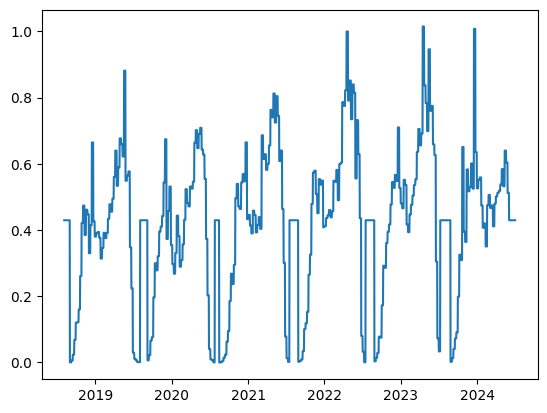

In [56]:
from matplotlib import pyplot
print(y)
pyplot.plot(y)
pyplot.show()

In [57]:
nan_count = np.isnan(y).sum()
print(f'NaNの数: {nan_count}')

NaNの数: 0


In [58]:
X.shape, y.shape

((2157, 59), (2157,))

In [59]:
X_train, X_val, X_test, y_train, y_val, y_test = ut.train_val_test_split2(X, y, '2022-08-06', '2024-4-01')

In [60]:
X_train.shape, y_train.shape

((1462, 59), (1462,))

In [61]:
# スケーラーを初期化
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# トレーニングデータのみに対してフィッティング
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.fit_transform(y_val.values.reshape(-1, 1))

# テストデータをトレーニングデータのスケールに変換
X_test_scaled = scaler_X.transform(X_test)


In [62]:
# 欠損値がある場合は補間
if np.isnan(X_train_scaled).sum() > 0:
    # 平均値で置換
    imputer = SimpleImputer(strategy='mean')
    X_train_scaled = imputer.fit_transform(X_train_scaled)

if np.isnan(X_val_scaled).sum() > 0:
    # 平均値で置換
    imputer = SimpleImputer(strategy='mean')
    X_val_scaled = imputer.fit_transform(X_val_scaled)

if np.isnan(X_test_scaled).sum() > 0:
    # 平均値で置換
    imputer = SimpleImputer(strategy='mean')
    X_test_scaled = imputer.fit_transform(X_test_scaled)

In [63]:
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_train_scaled)
print(y_train_scaled)

(1462, 59) (1462, 1)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00023714 0.00055191 0.         ... 0.         0.         0.        ]
 [0.00023714 0.00055191 0.         ... 0.         0.         0.        ]
 [0.00023714 0.00055191 0.         ... 0.         0.         0.        ]]
[[0.42968174]
 [0.42968174]
 [0.42968174]
 ...
 [0.42968174]
 [0.42968174]
 [0.42968174]]


In [64]:
print(y_train_scaled[14:100])
print(y_train_scaled[-30:])

[[4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [4.29681739e-01]
 [3.15578297e-04]
 [3.15578297e-04]
 [3.15578297e-04]
 [3.15578297e-04]
 [3.15578297e-04]
 [3.15578297e-04]
 [3.15578297e-04]
 [5.86073981e-03]
 [5.86073981e-03]
 [5.86073981e-03]
 [5.86073981e-03]
 [5.86073981e-03]
 [5.86073981e-03]
 [5.86073981e-03]
 [2.36593558e-02]
 [2.36593558e-02]
 [2.36593558e-02]
 [2.36593558e-02]
 [2.36593558e-02]
 [2.36593558e-02]
 [2.36593558e-02]
 [6.84534409e-02]
 [6.84534409e-02]
 [6.84534409e-02]
 [6.84534409e-02]
 [6.84534409e-02]
 [6.84534409e-02]
 [6.84534409e-02]
 [1.20226315e-01]
 [1.20226315e-01]
 [1.20226315e-01]
 [1.20226315e-01]
 [1.20226315e-01]
 [1.20226315e-01]
 [1.20226315e-01]
 [1.21470595e-01]
 [1.21470595e-01]
 [1.21470595e-01]
 [1.21470595e-01]
 [1.21470595e-01]
 [1.21470595e-01]
 [1.21470595e-01]
 [1.602055

In [65]:
X_train_scaled.shape, y_train_scaled.shape

((1462, 59), (1462, 1))

In [66]:
# モデルの入力に合わせてデータを整形
# X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
# X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
# X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [67]:
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_train_scaled)

(1462, 1, 59) (1462, 1)
[[[0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]]

 ...

 [[0.00023714 0.00055191 0.         ... 0.         0.         0.        ]]

 [[0.00023714 0.00055191 0.         ... 0.         0.         0.        ]]

 [[0.00023714 0.00055191 0.         ... 0.         0.         0.        ]]]


In [68]:
# データセットのサイズ確認
len(X_train), len(X_val), len(X_test)

(1462, 605, 92)

In [69]:
# データセットの形状確認
X_train_scaled.shape, y_train_scaled.shape, X_val_scaled.shape, y_val_scaled.shape, X_test_scaled.shape

((1462, 1, 59), (1462, 1), (605, 1, 59), (605, 1), (92, 1, 59))

In [70]:
# データの形状が (n_samples, 1, n_features) なので、(n_samples, n_features) に変換
X_train = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[2])
y_train = y_train_scaled.reshape(y_train_scaled.shape[0])
X_val = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[2])
y_val = y_val_scaled.reshape(y_val_scaled.shape[0])
X_test = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[2])

In [71]:
nan_count = np.isnan(y_train).sum()
print(f'NaNの数: {nan_count}')
nan_count = np.isnan(y_val).sum()
print(f'NaNの数: {nan_count}')
print(len(y_train), len(y_val))

NaNの数: 0
NaNの数: 0
1462 605


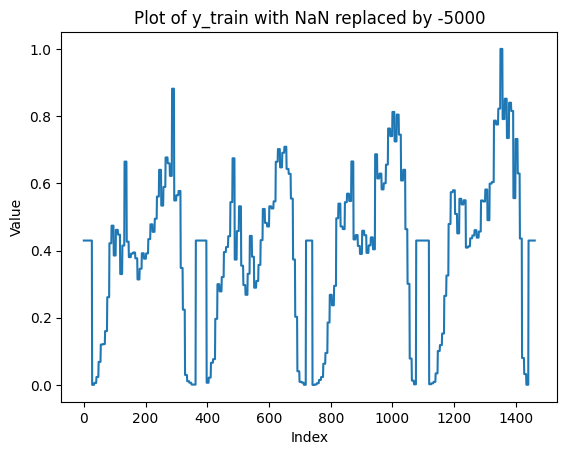

In [72]:
# NaNを-5000に変換
y_train_nan = np.where(np.isnan(y_train), -0.3, y_train)

# プロット
plt.plot(y_train_nan)
plt.title('Plot of y_train with NaN replaced by -5000')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

最適化がリセットされる恐れがあるからnanは0埋めでなく削除のほうがいいかも

In [73]:
# NaNを0に変換
y_train = np.where(np.isnan(y_train), 0, y_train)
y_val = np.where(np.isnan(y_val), 0, y_val)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estim

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
242 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.8/dist-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/utils/_p

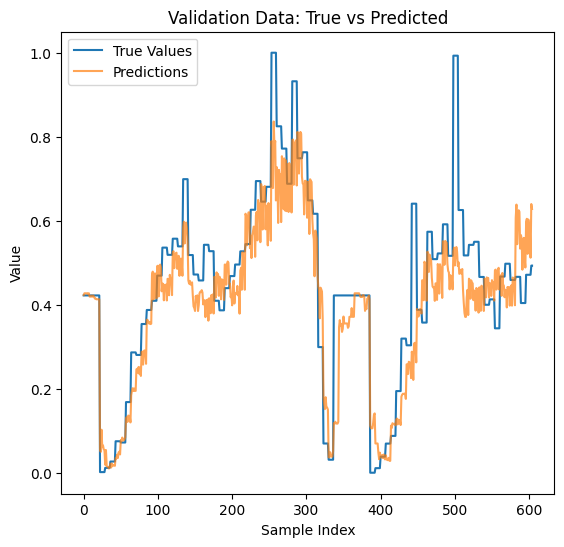

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# パラメータグリッドの定義
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# ランダムフォレストモデルのインスタンスを作成
rf = RandomForestRegressor(random_state=42)

# グリッドサーチCVの設定
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# グリッドサーチを実行して最適なパラメータを見つける
grid_search.fit(X_train, y_train)

# 最適なパラメータを出力
print(f'Best parameters found: {grid_search.best_params_}')

# 最適なパラメータで再度モデルを作成
best_rf = grid_search.best_estimator_

# 検証データで予測
y_val_pred = best_rf.predict(X_val)

# 検証データのRMSEを計算
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'Validation RMSE: {val_rmse}')

# テストデータで予測
y_test_pred = best_rf.predict(X_test)

# 必要であれば、テストデータのRMSEも計算
# test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
# print(f'Test RMSE: {test_rmse}')

# 予測値と真値をプロットして比較
plt.figure(figsize=(14, 6))

# 検証データ
plt.subplot(1, 2, 1)
plt.plot(y_val, label='True Values')
plt.plot(y_val_pred, label='Predictions', alpha=0.7)
plt.title('Validation Data: True vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()



In [75]:
import itertools
import os
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# パラメータグリッドの定義
# パラメータグリッドの定義
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

param_combinations = list(itertools.product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf'],
    param_grid['max_features'],
    param_grid['bootstrap']
))


In [76]:

# 保存先を指定
tracking_uri = '/home/code/mlflow/mlruns'
mlflow.set_tracking_uri(tracking_uri)

experiment_name = "RF_experiment"
mlflow.set_experiment(experiment_name)

# experiment_idを取得
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id


2024/06/18 16:43:16 INFO mlflow.tracking.fluent: Experiment with name 'RF_experiment' does not exist. Creating a new experiment.


In [77]:

for params in param_combinations:
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, bootstrap = params
    with mlflow.start_run(experiment_id=experiment_id):
        # モデルのインスタンスを作成
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42
        )

        # モデルを訓練データで学習
        rf.fit(X_train, y_train)

        # 検証データで予測
        y_val_pred = rf.predict(X_val)

        # 検証データのRMSEを計算
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        # モデルのパラメータを記録
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        mlflow.log_param("min_samples_leaf", min_samples_leaf)
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("bootstrap", bootstrap)

        # 損失を記録
        mlflow.log_metric('val_rmse', val_rmse)

        # 検証データに対する予測結果をCSVで保存
        df_val = pd.DataFrame(X_val)
        df_val['Ans'] = y_val
        df_val['Pred'] = y_val_pred
        df_val.to_csv('/home/code/mlflow/artifacts/csv/val_pred.csv', index=False)
        mlflow.log_artifact('/home/code/mlflow/artifacts/csv/val_pred.csv')

        # テストデータでの予測
        y_test_pred = rf.predict(X_test)
        df_test = pd.DataFrame(X_test)
        df_test['Ans'] = y_test
        df_test['Pred'] = y_test_pred
        df_test.to_csv('/home/code/mlflow/artifacts/csv/test_pred.csv', index=False)
        mlflow.log_artifact('/home/code/mlflow/artifacts/csv/test_pred.csv')

        # df_valにおいて、誤差と絶対誤差を計算
        df_val['Error'] = df_val['Ans'] - df_val['Pred']
        df_val['Abs Error'] = abs(df_val['Error'])

        # 最大誤差、最小誤差、平均誤差を計算（Abs Errorが0の行を除いて計算）
        val_max_error = df_val[df_val['Abs Error'] != 0]['Abs Error'].max()
        val_min_error = df_val[df_val['Abs Error'] != 0]['Abs Error'].min()
        val_mean_abs_error = df_val[df_val['Abs Error'] != 0]['Abs Error'].mean()
        mlflow.log_metric('val_max_error', val_max_error)
        mlflow.log_metric('val_min_error', val_min_error)
        mlflow.log_metric('val_mean_abs_error', val_mean_abs_error)

        # 予測結果をプロット
        plt.figure(figsize=(10, 5))
        plt.plot(df_val['Ans'].values, label='Actual')
        plt.plot(df_val['Pred'].values, label='Predict')
        plt.legend()
        plt.savefig('/home/code/mlflow/artifacts/images/val_pred.png')
        mlflow.log_artifact('/home/code/mlflow/artifacts/images/val_pred.png')
        plt.close()

        # モデルの保存
        mlflow.sklearn.log_model(rf, "models")

        print(f'Params: {params}, Validation RMSE: {val_rmse}')

2024/06/18 16:43:16 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

/usr/local/lib/python3.8/dist-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replac

Params: (100, None, 2, 1, 'sqrt', True), Validation RMSE: 0.108157246908551
Params: (100, None, 2, 1, 'sqrt', False), Validation RMSE: 0.10694167116163877
Params: (100, None, 2, 1, 'log2', True), Validation RMSE: 0.11043446206749911
Params: (100, None, 2, 1, 'log2', False), Validation RMSE: 0.10848511123407806
Params: (100, None, 2, 2, 'sqrt', True), Validation RMSE: 0.11319131608668652
Params: (100, None, 2, 2, 'sqrt', False), Validation RMSE: 0.10989836433630844
Params: (100, None, 2, 2, 'log2', True), Validation RMSE: 0.11463656310810387
Params: (100, None, 2, 2, 'log2', False), Validation RMSE: 0.10963147199604989
Params: (100, None, 2, 4, 'sqrt', True), Validation RMSE: 0.1132304967894735
Params: (100, None, 2, 4, 'sqrt', False), Validation RMSE: 0.11211012907006151
Params: (100, None, 2, 4, 'log2', True), Validation RMSE: 0.11901830978159308
Params: (100, None, 2, 4, 'log2', False), Validation RMSE: 0.11264141016958513
Params: (100, None, 5, 1, 'sqrt', True), Validation RMSE: 0.1